Vartional Quantum Eigensolve (VQE) is an algorithm that uses classical and quantum computing in conjunction to accomplish a task. There are 4 main components of a VQE calculation:
An operator: Often a Hamiltonian, we tend to seek the eigenvector of this operator that corresponds to the minimum eigenvalue. We often call that eigenvector the “ground state”.
An “ansatz” (a German word meaning “approach”): this is a quantum circuit that prepares a quantum state approximating the eigenvector you’re seeking.
An estimator: a means of estimating the expectation value of the operator H over the current variational quantum state.
A classical optimizer: an algorithm that varies parameters to try to minimize the cost function.

Below I attempt to contstruct a Ansatz using rotational x and z gates, before adding a entangling layer. This can provide a nice insight in a comparison to prebuild ansatz from IBM such as the efficientSU2 ansatz

In [1]:
from qiskit.circuit import Parameter, QuantumCircuit, ParameterVector
import numpy as np
from molecules import h2_qubit_hamiltonian, exact_energy

qubit_op, problem = h2_qubit_hamiltonian(0.75)
num_qubits = qubit_op.num_qubits

def hardware_efficient_ansatz(num_qubits, depth):
    qc = QuantumCircuit(num_qubits)

    # Create parameters
    num_params = 2 * num_qubits * depth
    params = ParameterVector("θ", num_params)
    
    param_idx = 0

    for d in range(depth):
        # Single-qubit rotations
        for q in range(num_qubits):
            qc.ry(params[param_idx], q)
            param_idx += 1
            qc.rz(params[param_idx], q)
            param_idx += 1

        # Entangling layer (linear chain)
        for q in range(num_qubits - 1):
            qc.cx(q, q + 1)

    return qc



Here I import my two optimizers that I will be working with. COPYLA and SPSA, And I included the Estimator. 

In [2]:
from qiskit_algorithms.minimum_eigensolvers import VQE
from qiskit_algorithms.optimizers import COBYLA, SPSA
from qiskit.primitives import Estimator
from qiskit_aer.primitives import Estimator as AerEstimator  

shots = 2000  # your fixed shot budget per evaluation

# Option 1: pure primitive with finite shots
estimator = Estimator(options={"shots": shots})

# Option 2 (if you want noise/readout models later):
# estimator = AerEstimator(run_options={"shots": shots})

ansatz = hardware_efficient_ansatz(num_qubits, depth=2)


I decided it would be good to test the Ansatz that I built to a predefined ansatz through IBM.

In [3]:
from qiskit.circuit.library import TwoLocal

ansatz = TwoLocal(
    num_qubits=num_qubits,
    rotation_blocks=["ry", "rz"],
    entanglement_blocks="cx",
    entanglement="linear",
    reps=2,
)


In [4]:
depths = [1,2,3]
optimizers = {
    "COBYLA": COBYLA(maxiter=200),
    "SPSA" : SPSA(maxiter=200)
}

R_values = np.linspace(0.3, 2.0, 10)
results = []

for R in R_values:
    qubit_op, problem = h2_qubit_hamiltonian(R)
    num_qubits = qubit_op.num_qubits

    for depth in depths:
        for name, opt in optimizers.items():
            ansatz = hardware_efficient_ansatz(num_qubits, depth)

            vqe = VQE(
                estimator=estimator,
                ansatz=ansatz,
                optimizer=opt,
            )

            res = vqe.compute_minimum_eigenvalue(qubit_op)
            E_exact = exact_energy(qubit_op, problem)

            results.append({
                "R": R,
                "depth": depth,
                "optimizer": name,
                "energy": res.eigenvalue.real + problem.nuclear_repulsion_energy,
                "energy_exact": E_exact,
                "iters": res.optimizer_result.nfev,
            })


In [5]:
two_local_results = []

depth = 2   # reps in TwoLocal
optimizer = COBYLA(maxiter=200)
estimator = Estimator()

for R in R_values:
    qubit_op, problem = h2_qubit_hamiltonian(R)
    num_qubits = qubit_op.num_qubits

    two_local_ansatz = TwoLocal(
        num_qubits=num_qubits,
        rotation_blocks=["ry", "rz"],
        entanglement_blocks="cz",
        entanglement="full",
        reps=depth,
        parameter_prefix="θ",
    )

    vqe = VQE(
        estimator=estimator,
        ansatz=two_local_ansatz,
        optimizer=optimizer,
    )

    res = vqe.compute_minimum_eigenvalue(qubit_op)

    two_local_results.append({
        "R": R,
        "energy": res.eigenvalue.real + problem.nuclear_repulsion_energy,
        "reps": depth,
        "optimizer": "COBYLA",
    })
    


In [6]:
import matplotlib.pyplot as plt

R_vals = sorted(set(r["R"] for r in results))

E_vqe = []
E_exact = []

for R in R_vals:
    vals = [r for r in results if r["R"] == R]
    E_vqe.append(vals[0]["energy"])   # only one depth/optimizer
    E_exact.append(exact_energy(*h2_qubit_hamiltonian(R)))


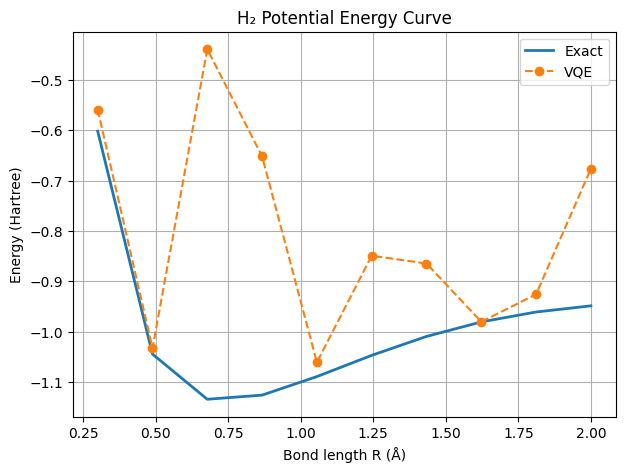

In [7]:
plt.figure(figsize=(7, 5))

plt.plot(R_vals, E_exact, label="Exact", linewidth=2)
plt.plot(R_vals, E_vqe, marker="o", linestyle="--", label="VQE")

plt.xlabel("Bond length R (Å)")
plt.ylabel("Energy (Hartree)")
plt.title("H₂ Potential Energy Curve")
plt.legend()
plt.grid(True)
plt.show()




In [8]:
def extract_curve(results, depth, optimizer):
    R = []
    E = []

    for entry in results:
        if entry["depth"] == depth and entry["optimizer"] == optimizer:
            R.append(entry["R"])
            E.append(entry["energy"])

    # Sort by R (important!)
    R, E = zip(*sorted(zip(R, E)))
    return R, E

def extract_exact_curve(results):
    exact_dict = {}

    for entry in results:
        R = entry["R"]
        if R not in exact_dict:
            exact_dict[R] = entry["energy_exact"]

    R_exact = sorted(exact_dict.keys())
    E_exact = [exact_dict[R] for R in R_exact]

    return R_exact, E_exact


R_exact, E_exact = extract_exact_curve(results)

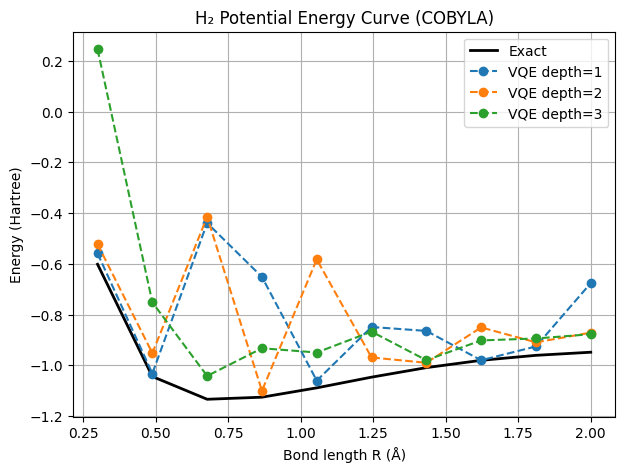

In [9]:
plt.figure(figsize=(7, 5))

plt.plot(R_exact, E_exact, color="black", linewidth=2, label="Exact")

for depth in [1, 2, 3]:
    R, E = extract_curve(results, depth, "COBYLA")
    plt.plot(
        R, E,
        marker="o",
        linestyle="--",
        label=f"VQE depth={depth}"
    )

plt.xlabel("Bond length R (Å)")
plt.ylabel("Energy (Hartree)")
plt.title("H₂ Potential Energy Curve (COBYLA)")
plt.legend()
plt.grid(True)
plt.show()


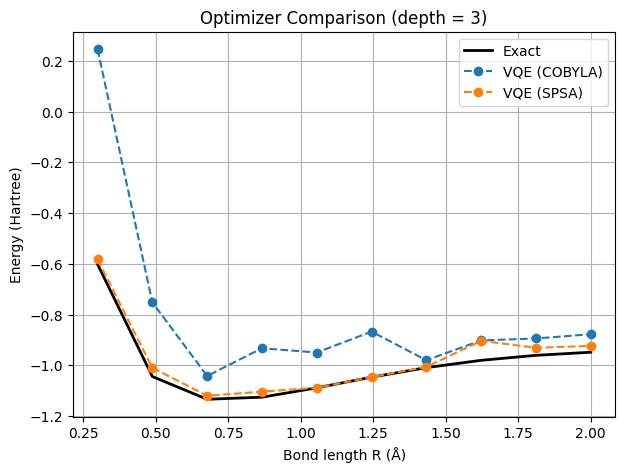

In [10]:
plt.figure(figsize=(7, 5))

plt.plot(R_exact, E_exact, color="black", linewidth=2, label="Exact")

for optimizer in ["COBYLA", "SPSA"]:
    R, E = extract_curve(results, depth=3, optimizer=optimizer)
    plt.plot(
        R, E,
        marker="o",
        linestyle="--",
        label=f"VQE ({optimizer})"
    )

plt.xlabel("Bond length R (Å)")
plt.ylabel("Energy (Hartree)")
plt.title("Optimizer Comparison (depth = 3)")
plt.legend()
plt.grid(True)
plt.show()



Here is the graph for Exact energies vs Two Local

In [11]:
R_exact = []
E_exact = []

for R in R_values:
    qubit_op, problem = h2_qubit_hamiltonian(R)
    E_exact.append(exact_energy(qubit_op, problem))
    R_exact.append(R)
    
R_tl = [entry["R"] for entry in two_local_results]
E_tl = [entry["energy"] for entry in two_local_results]


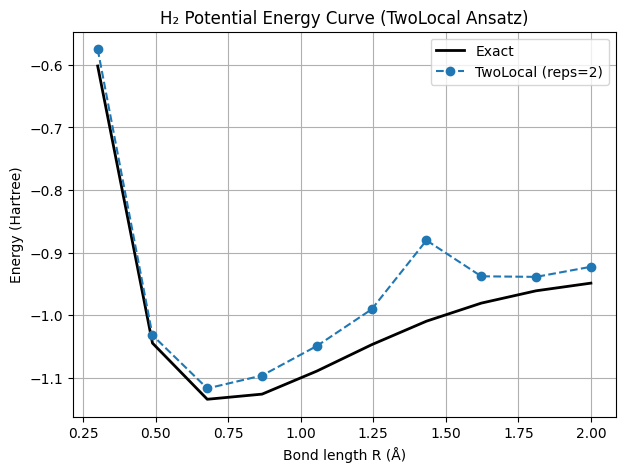

In [12]:

plt.figure(figsize=(7, 5))

plt.plot(R_exact, E_exact, color="black", linewidth=2, label="Exact")
plt.plot(R_tl, E_tl, marker="o", linestyle="--", label="TwoLocal (reps=2)")

plt.xlabel("Bond length R (Å)")
plt.ylabel("Energy (Hartree)")
plt.title("H₂ Potential Energy Curve (TwoLocal Ansatz)")
plt.legend()
plt.grid(True)
plt.show()


And now for my Custom Ansatz versus the TwoLocal

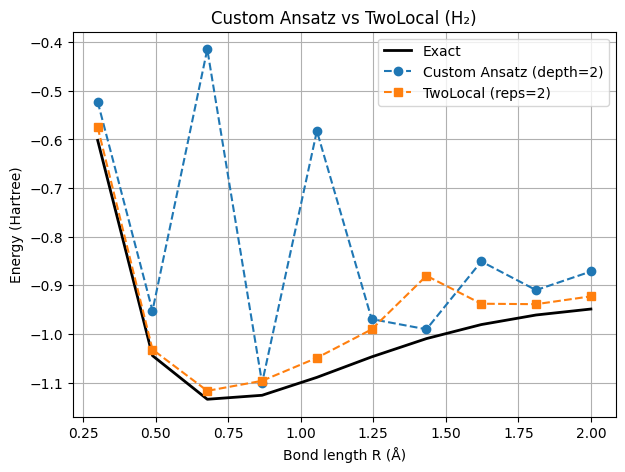

In [13]:
R_custom = []
E_custom = []

for entry in results:
    if entry["depth"] == 2 and entry["optimizer"] == "COBYLA":
        R_custom.append(entry["R"])
        E_custom.append(entry["energy"])

# Sort
R_custom, E_custom = zip(*sorted(zip(R_custom, E_custom)))

plt.figure(figsize=(7, 5))

plt.plot(R_exact, E_exact, color="black", linewidth=2, label="Exact")
plt.plot(R_custom, E_custom, marker="o", linestyle="--", label="Custom Ansatz (depth=2)")
plt.plot(R_tl, E_tl, marker="s", linestyle="--", label="TwoLocal (reps=2)")

plt.xlabel("Bond length R (Å)")
plt.ylabel("Energy (Hartree)")
plt.title("Custom Ansatz vs TwoLocal (H₂)")
plt.legend()
plt.grid(True)
plt.show()



### Noise comparison demo

The next cell runs a small noisy vs noiseless comparison for H2 using the provided runner.
Adjust `R_values`, `shots`, and `repeats` to control accuracy and runtime.

In [ ]:
# Estimate equilibrium bond length Re and equilibrium energy E(Re)
# Uses exact diagonalization on a fine grid and quadratic interpolation
import numpy as np

R_fine = np.linspace(0.3, 2.0, 401)  # fine grid
E_fine = np.empty_like(R_fine)

for i, R in enumerate(R_fine):
    qubit_op, problem = h2_qubit_hamiltonian(R)
    E_fine[i] = exact_energy(qubit_op, problem)

# Find index of minimum energy
idx = int(np.argmin(E_fine))

# Quadratic interpolation around the minimum for a refined estimate
if 0 < idx < len(R_fine) - 1:
    x = R_fine[idx - 1: idx + 2]
    y = E_fine[idx - 1: idx + 2]
    a, b, c = np.polyfit(x, y, 2)
    R_est = -b / (2 * a)
    E_est = a * R_est ** 2 + b * R_est + c
else:
    R_est = R_fine[idx]
    E_est = E_fine[idx]

print(f"Estimated equilibrium bond length Re = {R_est:.6f} Å")
print(f"Estimated equilibrium energy E(Re) = {E_est:.6f} Ha")